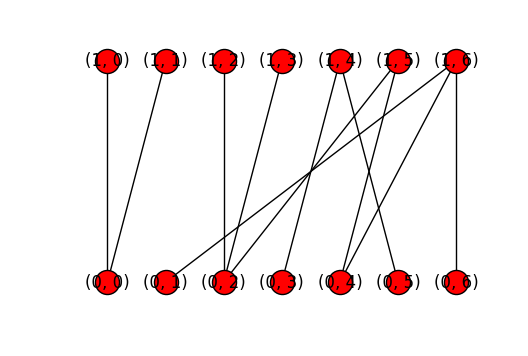

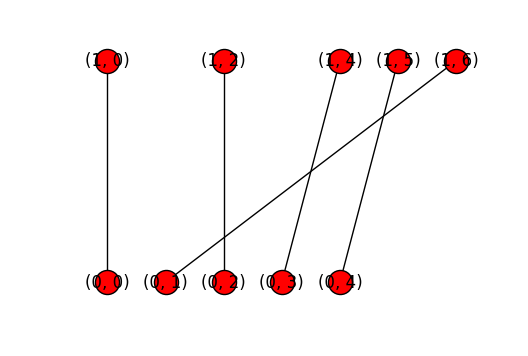

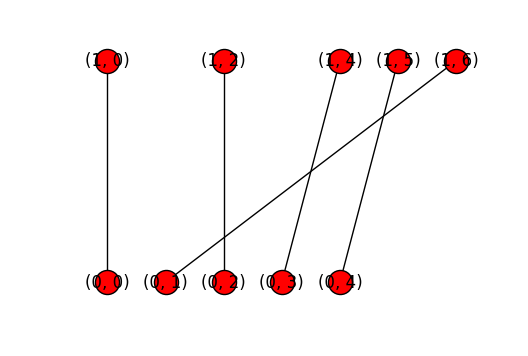

In [2]:
import networkx as nx
from networkx import bipartite

def plotGraph(graph):
    import matplotlib.pyplot as plt
    fig=plt.figure()
    ax=fig.add_subplot(111)

    pos=[(ii[1],ii[0]) for ii in graph.nodes()]
    pos_dict=dict(zip(graph.nodes(),pos))
    nx.draw(graph,pos=pos_dict,ax=ax,with_labels=True)
    plt.show(block=False)
    return


def formDirected(g,match):
    '''Form directed graph D from G and matching M.

    <g>: undirected bipartite graph. Nodes are separated by their
         'bipartite' attribute.
    <match>: list of edges forming a matching of <g>. 

    Return <d>: directed graph, with edges in <match> pointing from set-0
                (bipartite attribute ==0) to set-1 (bipartite attrbiute==1),
                and the other edges in <g> but not in <matching> pointing
                from set-1 to set-0.
    '''

    d=nx.DiGraph()

    for ee in g.edges():
        if ee in match or (ee[1],ee[0]) in match:
            if g.node[ee[0]]['bipartite']==0:
                d.add_edge(ee[0],ee[1])
            else:
                d.add_edge(ee[1],ee[0])
        else:
            if g.node[ee[0]]['bipartite']==0:
                d.add_edge(ee[1],ee[0])
            else:
                d.add_edge(ee[0],ee[1])

    return d


def enumMaximumMatching(g):
    '''Find all maximum matchings in an undirected bipartite graph.

    <g>: undirected bipartite graph. Nodes are separated by their
         'bipartite' attribute.

    Return <all_matches>: list, each is a list of edges forming a maximum
                          matching of <g>. 
    '''

    all_matches=[]

    #----------------Find one matching M----------------
    match=bipartite.hopcroft_karp_matching(g)

    #---------------Re-orient match arcs---------------
    match2=[]
    for kk,vv in match.items():
        if g.node[kk]['bipartite']==0:
            match2.append((kk,vv))
    match=match2
    all_matches.append(match)

    #-----------------Enter recursion-----------------
    all_matches=enumMaximumMatchingIter(g,match,all_matches,None)

    return all_matches


def enumMaximumMatchingIter(g,match,all_matches,add_e=None):
    '''Recurively search maximum matchings.

    <g>: undirected bipartite graph. Nodes are separated by their
         'bipartite' attribute.
    <match>: list of edges forming one maximum matching of <g>.
    <all_matches>: list, each is a list of edges forming a maximum
                   matching of <g>. Newly found matchings will be appended
                   into this list.
    <add_e>: tuple, the edge used to form subproblems. If not None,
             will be added to each newly found matchings.

    Return <all_matches>: updated list of all maximum matchings.
    '''

    #---------------Form directed graph D---------------
    d=formDirected(g,match)

    #-----------------Find cycles in D-----------------
    cycles=list(nx.simple_cycles(d))

    if len(cycles)==0:

        #---------If no cycle, find a feasible path---------
        all_uncovered=set(g.node).difference(set([ii[0] for ii in match]))
        all_uncovered=all_uncovered.difference(set([ii[1] for ii in match]))
        all_uncovered=list(all_uncovered)

        #--------------If no path, terminiate--------------
        if len(all_uncovered)==0:
            return all_matches

        #----------Find a length 2 feasible path----------
        idx=0
        uncovered=all_uncovered[idx]
        while True:

            if uncovered not in nx.isolates(g):
                paths=nx.single_source_shortest_path(d,uncovered,cutoff=2)
                len2paths=[vv for kk,vv in paths.items() if len(vv)==3]

                if len(len2paths)>0:
                    reversed=False
                    break

                #----------------Try reversed path----------------
                paths_rev=nx.single_source_shortest_path(d.reverse(),uncovered,cutoff=2)
                len2paths=[vv for kk,vv in paths_rev.items() if len(vv)==3]

                if len(len2paths)>0:
                    reversed=True
                    break

            idx+=1
            if idx>len(all_uncovered)-1:
                return all_matches

            uncovered=all_uncovered[idx]

        #-------------Create a new matching M'-------------
        len2path=len2paths[0]
        if reversed:
            len2path=len2path[::-1]
        len2path=zip(len2path[:-1],len2path[1:])

        new_match=[]
        for ee in d.edges():
            if ee in len2path:
                if g.node[ee[1]]['bipartite']==0:
                    new_match.append((ee[1],ee[0]))
            else:
                if g.node[ee[0]]['bipartite']==0:
                    new_match.append(ee)

        if add_e is not None:
            for ii in add_e:
                new_match.append(ii)

        all_matches.append(new_match)

        #---------------------Select e---------------------
        #import pdb
        #pdb.set_trace()
        e=set(len2path).difference(set(match))
        if len(e)==0:
            return all_matches #This fixes a crash, but I don't know if it's correct!
        e=list(e)[0]

        #-----------------Form subproblems-----------------
        g_plus=g.copy()
        g_minus=g.copy()
        g_plus.remove_node(e[0])
        g_plus.remove_node(e[1])

        g_minus.remove_edge(e[0],e[1])

        add_e_new=[e,]
        if add_e is not None:
            add_e_new.extend(add_e)

        all_matches=enumMaximumMatchingIter(g_minus,match,all_matches,add_e)
        all_matches=enumMaximumMatchingIter(g_plus,new_match,all_matches,add_e_new)

    else:
        #----------------Find a cycle in D----------------
        cycle=cycles[0]
        cycle.append(cycle[0])
        cycle=zip(cycle[:-1],cycle[1:])

        #-------------Create a new matching M'-------------
        new_match=[]
        for ee in d.edges():
            if ee in cycle:
                if g.node[ee[1]]['bipartite']==0:
                    new_match.append((ee[1],ee[0]))
            else:
                if g.node[ee[0]]['bipartite']==0:
                    new_match.append(ee)

        if add_e is not None:
            for ii in add_e:
                new_match.append(ii)

        all_matches.append(new_match)

        #-----------------Choose an edge E-----------------
        e=set(match).intersection(set(cycle))
        if len(e)==0:
            return all_matches
        e=list(e)[0]
        

        #-----------------Form subproblems-----------------
        g_plus=g.copy()
        g_minus=g.copy()
        g_plus.remove_node(e[0])
        g_plus.remove_node(e[1])
        g_minus.remove_edge(e[0],e[1])

        add_e_new=[e,]
        if add_e is not None:
            add_e_new.extend(add_e)

        all_matches=enumMaximumMatchingIter(g_plus,match,all_matches,add_e_new)
        all_matches=enumMaximumMatchingIter(g_minus,new_match,all_matches,add_e)

    return all_matches

if __name__=='__main__':
    g=nx.Graph()
    edges=[
            [(1,0), (0,0)],
            [(1,1), (0,0)],
            [(1,2), (0,2)],
            [(1,3), (0,2)],
            [(1,4), (0,3)],
            [(1,4), (0,5)],
            [(1,5), (0,2)],
            [(1,5), (0,4)],
            [(1,6), (0,1)],
            [(1,6), (0,4)],
            [(1,6), (0,6)]
            ]

    for ii in edges:
        g.add_node(ii[0],bipartite=0)
        g.add_node(ii[1],bipartite=1)

    g.add_edges_from(edges)
    plotGraph(g)

    all_matches=enumMaximumMatching(g)

    for mm in all_matches:
        g_match=nx.Graph()
        for ii in mm:
            g_match.add_edge(ii[0],ii[1])
        plotGraph(g_match)

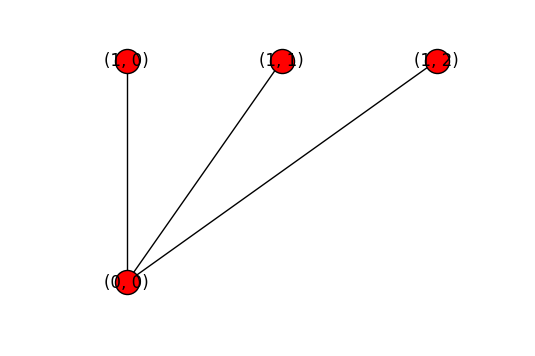

[[((1, 2), (0, 0))], [((1, 0), (0, 0))]]


In [9]:
import TestNetworks as tn
import DigraphConvert as dc

%matplotlib inline

g=nx.Graph()
edges=[
        [(1,0), (0,0)],
        [(1,1), (0,0)],
        [(1,2), (0,0)],
        ]



#g = tn.testNet(1)
#edges = g.edges()

for ii in edges:
    g.add_node(ii[0],bipartite=0)
    g.add_node(ii[1],bipartite=1)

g.add_edges_from(edges)
plotGraph(g)

#print(g.nodes(data=True))

all_matches=enumMaximumMatching(g)
print(all_matches)

[(1, 6), (2, 7), (3, 8)]
[(1, {'bipartite': 0}), (2, {'bipartite': 0}), (3, {'bipartite': 0}), (4, {'bipartite': 0}), (5, {'bipartite': 1}), (6, {'bipartite': 1}), (7, {'bipartite': 1}), (8, {'bipartite': 1})]


TypeError: 'int' object is not subscriptable

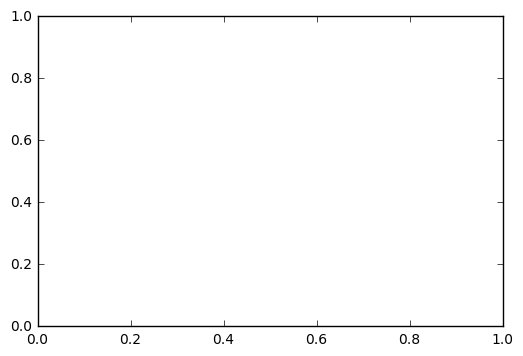

In [5]:
G = tn.testNet(1)
Gbi = dc.digraphToBipartite(G)
print(Gbi.edges())
print(Gbi.nodes(data=True))
plotGraph(Gbi)

all_matches=enumMaximumMatching(g)
print(all_matches)